# Capstone Project - Battle of the Neighborhoods

## Applied Data Science Capstone - IBM Coursera

### 1. Introduction: Business Problem - Opening a Japanese Restaurant

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese , Spanish , French etc.

If you're a stakeholder, entrepreneur, or chef interested in opening a Japanese restaurant in New York city, this will be for you.

Using efficient data science tools, we will suggest the promising locations to solve the below problems of finding out
-	Which areas in New York City have Japanese restaurants?
-	Which all areas lack Japanese Restaurants?
-	Which is the best location for Japanese restaurants in New York City?


### 2. Data Description

For this project we need the following data:

(1) New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
* Data source : https://cocl.us/new_york_dataset 
* Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of New York City.

(2) Japanese restaurants in each neighborhood of New York City.
* Data source : Fousquare API 
* Description : By using this API, we will get all the venues in each neighborhood. We can filter these venues to get only Japanese restaurants.

(3) GeoSpace data
* Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 
* Description : By using this geo space data we will get the New York Borough boundaries that will help us visualize choropleth map.


### 3. Methodology

(1) Collect the New York City data from https://cocl.us/new_york_dataset.

(2) Find all venues for each neighbourhood using FourSquare API.

(3) Filter out all venues that are Japanese Restaurants.

(4) Find rating, tips and like count for each Japanese Restaurants using FourSquare API.

(5) Sort the data using rating for each restaurant.

(6) Visualize the Ranking of neighborhoods using python's Folium library.

**Import necessary libraries**

In [4]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Folium installed')
print('Libraries imported.')

Matplotlib version:  3.0.2
Folium installed
Libraries imported.


Set Foursquare variables

In [79]:
CLIENT_ID = ['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = ['CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20200317' # Foursquare API version

Define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [33]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [34]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [35]:
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [36]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Call the above funtion to get the new york city data.

In [10]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york_data.shape

(306, 4)

**there are 306 different Neighborhoods in New York**

create a BAR PLOT to show different Neighborhoods in New York.

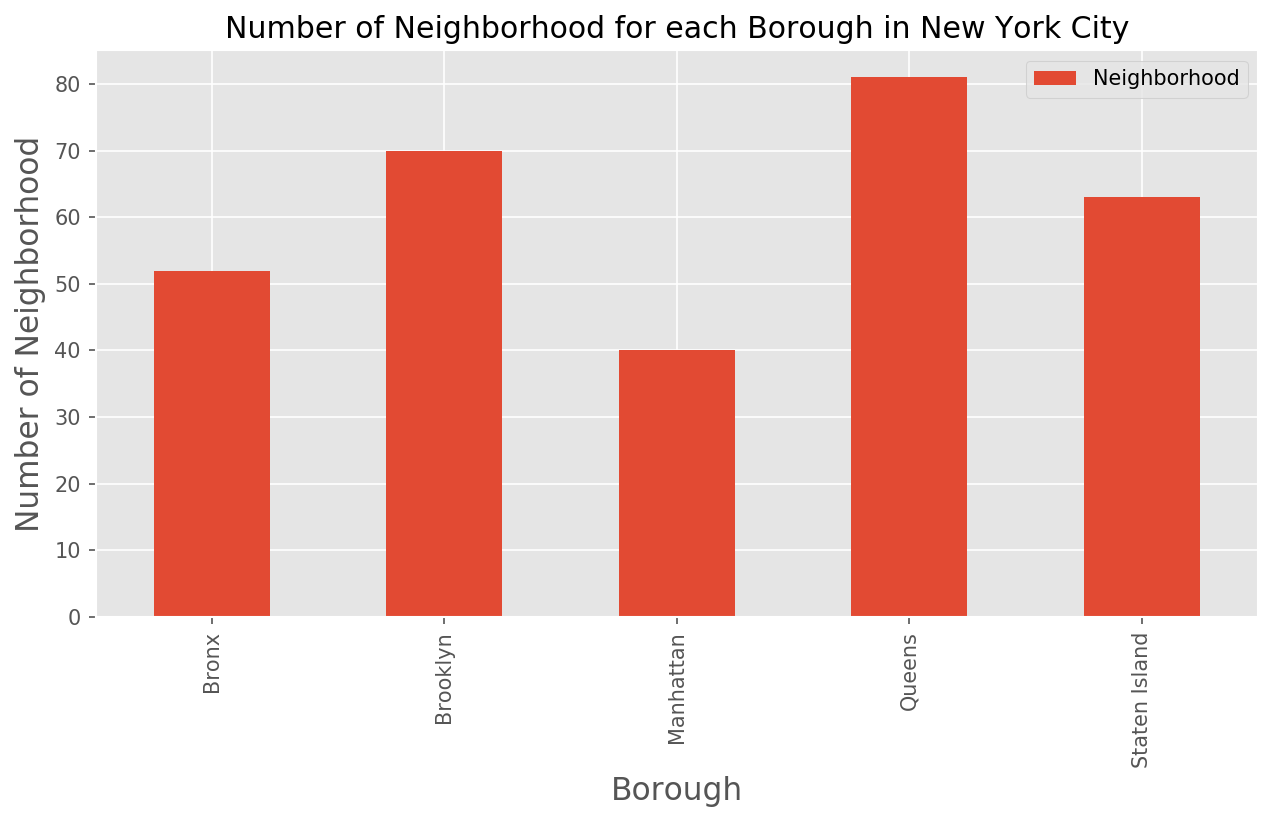

In [12]:
plt.figure(figsize=(10,5), dpi = 150)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

**We can see that Queens has highest number of neighborhoods.**

Collect Japanese resturants for each Neighborhood.

In [15]:
# prepare neighborhood list that contains Japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        Japanese_rest_ny = Japanese_rest_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood,
                                                    'ID': id,
                                                    'Name' : name
                                                   }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

Got all the Japanese resturants in new york city and analyze it.

In [16]:
Japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [17]:
Japanese_rest_ny.shape

(208, 4)

**Got 208 Japanese restaurants across New York City**

Create a BAR PLOT to show Number of Japanese resturants for each Borough in New York City.

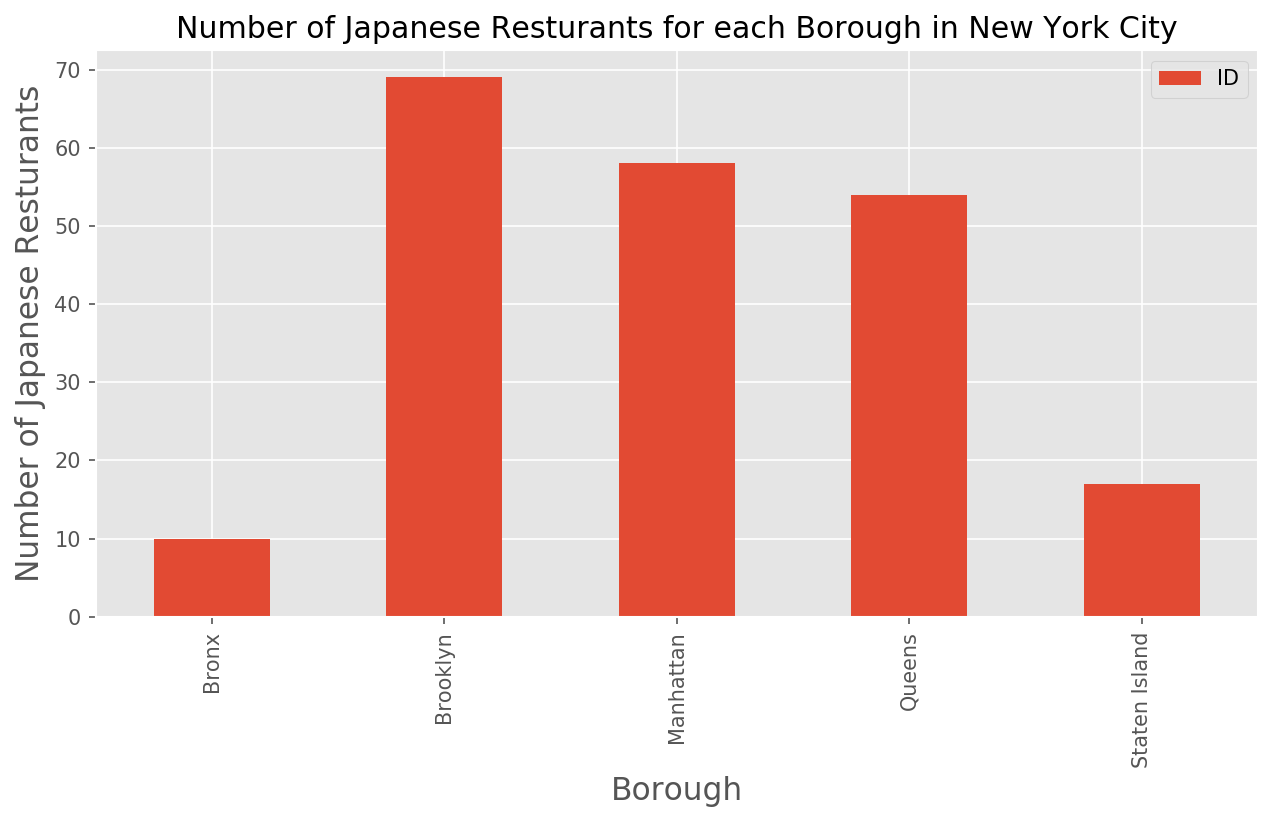

In [18]:
plt.figure(figsize=(10,5), dpi = 150)
# title
plt.title('Number of Japanese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Japanese Resturants', fontsize=15)
#giving a bar plot
Japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

 **We can see that Brooklyn has highest number of Japanese Resturants.**

Create a BAR PLOT to show Number of Japanese Resturants for each Neighborhood in New York City.

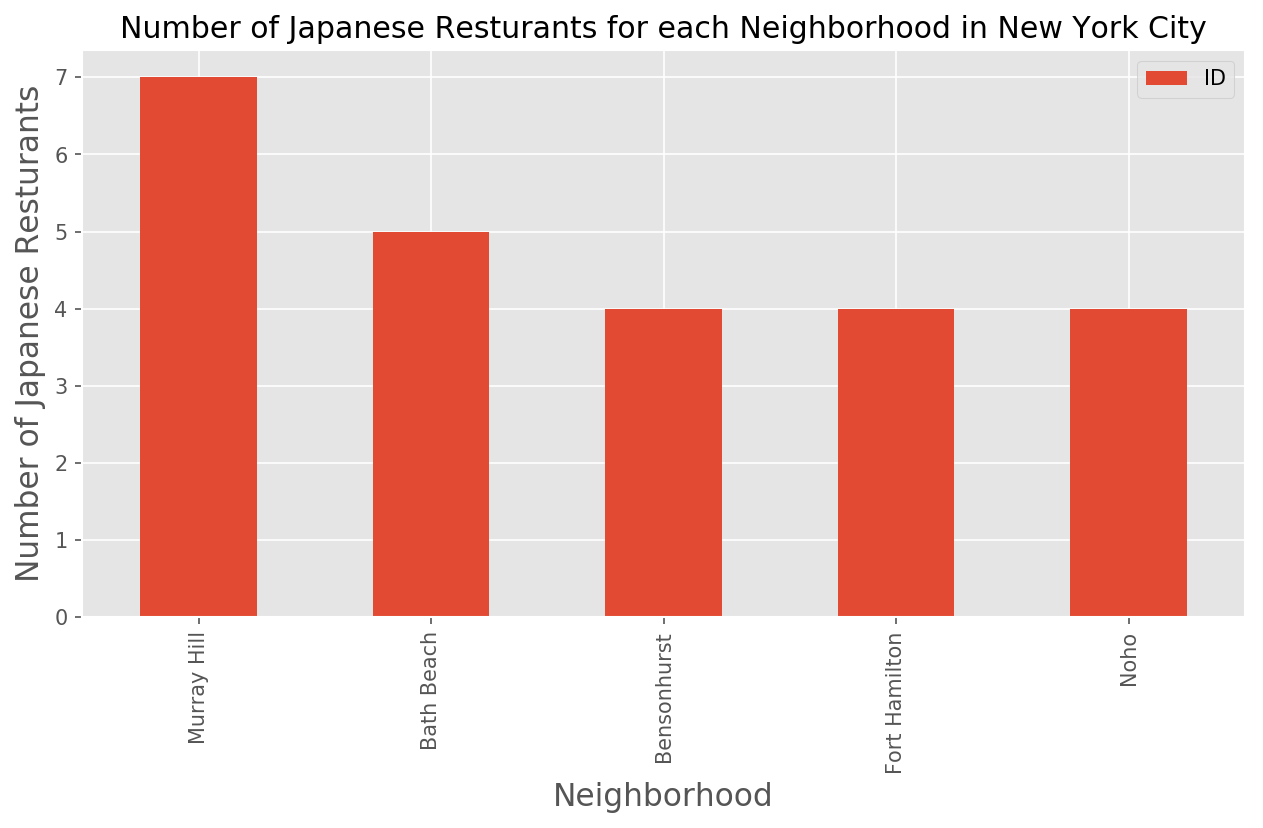

In [19]:
plt.figure(figsize=(10,5), dpi = 150)
# title
plt.title('Number of Japanese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Japanese Resturants', fontsize=15)
#giving a bar plot
Japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [20]:
Japanese_rest_ny[Japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
79,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
80,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
81,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
82,Manhattan,Murray Hill,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke
83,Manhattan,Murray Hill,5ad925da2f97ec3e4b17eba2,Nonono
131,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi
132,Queens,Murray Hill,5cf07afa66f3cd002c8b3ae6,Izakaya Mew


**We can see that, Murray Hill in Manhattan has the highest number of Japanese Resturants with a total count of 7.**

Get the ranking of each resturant for further analysis.

In [37]:
# prepare neighborhood list that contains Japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Japanese_rest_ny),')','processed')
    Japanese_rest_stats_ny = Japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     9.2    19
( 1 / 208 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.5    26
( 2 / 208 ) processed
                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     9.2    19
( 3 / 208 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.5    26
( 4 / 208 ) processed
                         ID                                         Name  \
0  4dbdf3d790a02849cbd675be  Ohana Japanese Habachi Seafood & Steakhouse   

   Likes  Rating  Tips  
0     34     7.5    18  
( 5 / 208 ) processed
                         ID      Name  Likes  Rating  Tips
0  5d40d7a398a00a0008b4c8ca  Benihana      0     7.7     0
( 6 /

In [38]:
Japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.2,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.2,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.5,18


In [39]:
Japanese_rest_stats_ny.shape

(208, 7)

In [40]:
Japanese_rest_ny.shape

(208, 4)

 Got data for all resturants Now lets save this data to a csv sheet. In case we modify it by mistake.

As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [41]:
Japanese_rest_stats_ny.to_csv('Japanese_rest_stats_ny.csv', index=False)

Verify the data from saved csv file

In [42]:
Japanese_rest_stats_ny_csv=pd.read_csv('Japanese_rest_stats_ny.csv')
Japanese_rest_stats_ny_csv.shape

(208, 7)

In [43]:
Japanese_rest_stats_ny_csv.shape

(208, 7)

In [44]:
Japanese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.2,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.2,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.5,18


In [45]:
Japanese_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 7 columns):
Borough         208 non-null object
Neighborhood    208 non-null object
ID              208 non-null object
Name            208 non-null object
Likes           208 non-null int64
Rating          208 non-null float64
Tips            208 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ KB


Convert type 'String' of both 'Likes' and 'Tips' into type 'Float' for further analysis.

In [46]:
Japanese_rest_stats_ny['Likes']=Japanese_rest_stats_ny['Likes'].astype('float64')
Japanese_rest_stats_ny['Tips']=Japanese_rest_stats_ny['Tips'].astype('float64')
Japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 7 columns):
Borough         208 non-null object
Neighborhood    208 non-null object
ID              208 non-null object
Name            208 non-null object
Likes           208 non-null float64
Rating          208 non-null float64
Tips            208 non-null float64
dtypes: float64(3), object(4)
memory usage: 11.5+ KB


Find the Japanese Restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [47]:
# Resturant with maximum Likes
Japanese_rest_stats_ny.iloc[Japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1221
Rating                               9.2
Tips                                 274
Name: 191, dtype: object

In [48]:
# Resturant with maximum Rating
Japanese_rest_stats_ny.iloc[Japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              52517e05498ec2e28c792fa2
Name               Brooklyn Ball Factory
Likes                                298
Rating                               9.3
Tips                                  89
Name: 57, dtype: object

In [49]:
# Resturant with maximum Tips
Japanese_rest_stats_ny.iloc[Japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                789
Rating                               8.9
Tips                                 353
Name: 85, dtype: object

 Visualize neighborhood with maximum average rating of resturants.

In [67]:
ny_neighborhood_stats=Japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [68]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
103,Stuyvesant Town,9.200000
80,Midtown South,9.150000
38,Flatiron,9.133333
33,East Village,9.133333
101,South Side,9.100000
24,Cobble Hill,9.100000
68,Little Italy,9.100000
19,Chinatown,9.100000
84,Noho,9.050000
85,North Side,9.050000


**Above are the top neighborhoods with top average rating of Japanese Resturant**

Find the average rating of Japanese Resturants for each Borough.

In [69]:
ny_borough_stats=Japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.720690
1,Brooklyn,7.662319
0,Bronx,7.590000
3,Queens,6.990741
4,Staten Island,5.852941


Create a BAR PLOT to show average rating of Japanese Resturants for each Borough.

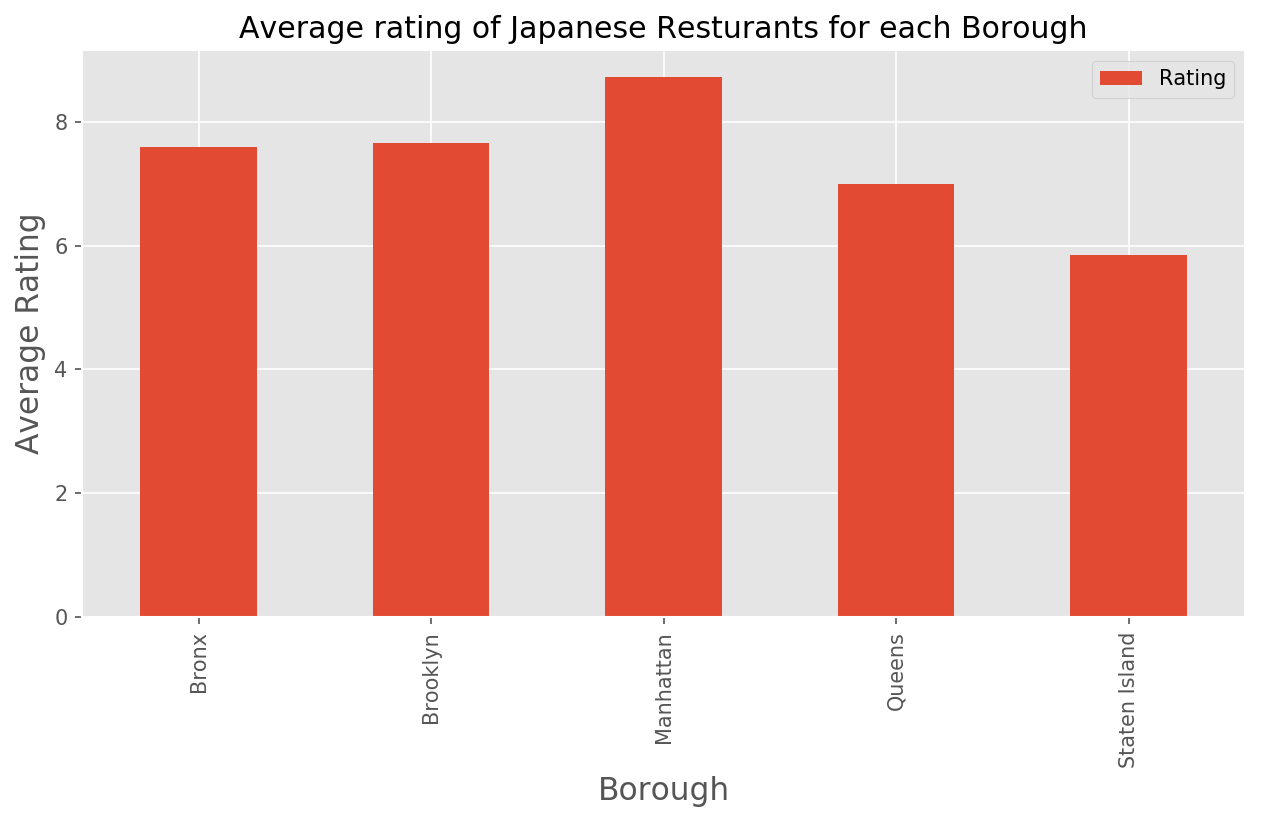

In [70]:
plt.figure(figsize=(10,5), dpi = 150)
# title
plt.title('Average rating of Japanese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [71]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
103,Stuyvesant Town,9.200000
80,Midtown South,9.150000
33,East Village,9.133333
38,Flatiron,9.133333
19,Chinatown,9.100000
24,Cobble Hill,9.100000
68,Little Italy,9.100000
101,South Side,9.100000
84,Noho,9.050000
85,North Side,9.050000


Join this dataset to original new york data to get lonitude and latitude.

In [72]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
12,Manhattan,Stuyvesant Town,40.731000,-73.974052,9.200000
8,Manhattan,Midtown South,40.748510,-73.988713,9.150000
3,Manhattan,East Village,40.727847,-73.982226,9.133333
5,Manhattan,Flatiron,40.739673,-73.990947,9.133333
0,Manhattan,Chinatown,40.715618,-73.994279,9.100000
2,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
7,Manhattan,Little Italy,40.719324,-73.997305,9.100000
11,Brooklyn,South Side,40.710861,-73.958001,9.100000
9,Manhattan,Noho,40.723259,-73.988434,9.050000
10,Brooklyn,North Side,40.714823,-73.958809,9.050000


 Show this data on a map.

In [74]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Add a new field to dataframe for labeling purpose.

In [78]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### 4. Results & Discussion

-	There are total of 306 different Neighborhoods in New York
-	We have 208 Japanese Restaurants across New York City
-	Stuyvesant has the highest average rating = 9.2 for Japanese Restaurants among all neighborhoods
-	Top 3 Boroughs with top average ranking of Japanese Restaurants are: Manhattan (8.72), Brooklyn (7.66) and Bronx (7.59)

### 5. Conclusion

The recommendation location to open Japanese Restaurant is Stuyvesant Town based on the best-rated Japanese Restaurant in New York.